--- STARTING SEISMIC RISK MONITOR (STYLED) ---
Fetching USGS Earthquakes data from live feed...
 -> Successfully loaded 676 records.
Fetching Global Cities data from live feed...
 -> Successfully loaded 243 records.

Analyzing impact (Mag > 4.0, Radius 50km)...
 -> identified 1 cities potentially impacted.
Generating Interactive Map...
Generating Statistics Chart...

Success! Files in 'risk_analysis_output'


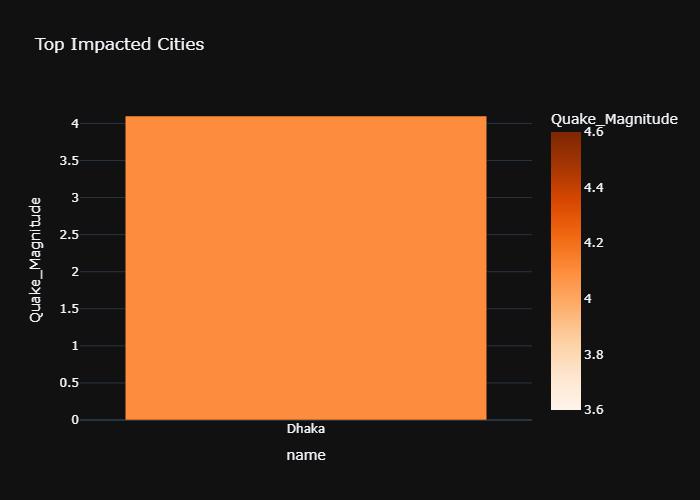


Interactive Map Preview:


In [6]:
#!/usr/bin/env python3
#################################################
# seismic_risk_monitor.py
#
# Real-time Seismic Risk Analysis Pipeline
# - Fetches live USGS Earthquake Feed (GeoJSON)
# - Fetches Natural Earth Populated Places (GeoJSON)
# - Performs Spatial Join to identify cities within 
#   impact radius of recent quakes (> Mag 4.0)
# - FIX: Robust Antimeridian (Date Line) handling
# - STYLE: Dark Mode, Heatmaps, and Enhanced Popups
# - CLEANUP: Resolved CRS and Deprecation Warnings
#
# - Written by Warren van Ryn
# - Created 11th December 2025
#################################################

import os
import sys
import math
import geopandas as gpd
import folium
from folium import plugins
import plotly.express as px
from shapely.geometry import box
from shapely.affinity import translate
from shapely.ops import unary_union

# Import IFrame for embedding maps in Notebooks
try:
    from IPython.display import display, Image, HTML, IFrame
except ImportError:
    display = None

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
URL_QUAKES = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"
URL_CITIES = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_populated_places_simple.geojson"

OUTPUT_DIR = "risk_analysis_output"
MIN_MAGNITUDE = 4.0
RISK_RADIUS_KM = 50

# Mercator projection bounds (Earth's circumference in meters)
MERCATOR_WORLD_MAX_X = 20037508.34
MERCATOR_WORLD_MIN_X = -20037508.34
MERCATOR_WIDTH = MERCATOR_WORLD_MAX_X - MERCATOR_WORLD_MIN_X

os.makedirs(OUTPUT_DIR, exist_ok=True)

def fetch_live_data(url, name):
    print(f"Fetching {name} data from live feed...")
    try:
        gdf = gpd.read_file(url)
        print(f" -> Successfully loaded {len(gdf)} records.")
        return gdf
    except Exception as e:
        print(f"Error fetching {name}: {e}")
        return gpd.GeoDataFrame()

def handle_antimeridian_buffers(gdf_mercator):
    """
    Splits geometries that cross the dateline in Web Mercator (EPSG:3857)
    into MultiPolygons on opposite sides of the map.
    """
    corrected_geoms = []
    large_y = 1e10 
    
    for geom in gdf_mercator.geometry:
        minx, miny, maxx, maxy = geom.bounds
        
        if maxx > MERCATOR_WORLD_MAX_X:
            inside_box = box(MERCATOR_WORLD_MIN_X, -large_y, MERCATOR_WORLD_MAX_X, large_y)
            part_main = geom.intersection(inside_box)
            overflow_box = box(MERCATOR_WORLD_MAX_X, -large_y, maxx + 1, large_y)
            part_overflow = geom.intersection(overflow_box)
            part_shifted = translate(part_overflow, xoff=-MERCATOR_WIDTH)
            corrected_geoms.append(unary_union([part_main, part_shifted]))
            
        elif minx < MERCATOR_WORLD_MIN_X:
            inside_box = box(MERCATOR_WORLD_MIN_X, -large_y, MERCATOR_WORLD_MAX_X, large_y)
            part_main = geom.intersection(inside_box)
            overflow_box = box(minx - 1, -large_y, MERCATOR_WORLD_MIN_X, large_y)
            part_overflow = geom.intersection(overflow_box)
            part_shifted = translate(part_overflow, xoff=MERCATOR_WIDTH)
            corrected_geoms.append(unary_union([part_main, part_shifted]))
            
        else:
            corrected_geoms.append(geom)
            
    return corrected_geoms

def perform_risk_analysis(quakes_gdf, cities_gdf, min_mag, radius_km):
    print(f"\nAnalyzing impact (Mag > {min_mag}, Radius {radius_km}km)...")
    
    if quakes_gdf.empty or cities_gdf.empty:
        print("Data unavailable. Skipping analysis.")
        return gpd.GeoDataFrame(), gpd.GeoDataFrame()

    sig_quakes = quakes_gdf[quakes_gdf['mag'] >= min_mag].copy()
    if sig_quakes.empty:
        print("No significant earthquakes found.")
        return gpd.GeoDataFrame(), gpd.GeoDataFrame()

    # 2. Project to Web Mercator (Meters)
    sig_quakes = sig_quakes.to_crs(epsg=3857)
    
    # 3. Create Buffers
    sig_quakes['geometry'] = sig_quakes.buffer(radius_km * 1000)
    
    # 4. APPLY ANTIMERIDIAN FIX
    sig_quakes['geometry'] = handle_antimeridian_buffers(sig_quakes)
    
    # 5. Project back to WGS84
    risk_zones = sig_quakes.to_crs(epsg=4326)
    risk_zones['geometry'] = risk_zones['geometry'].buffer(0)

    # 6. Spatial Join
    cities_w_risk = gpd.sjoin(cities_gdf, risk_zones, how="inner", predicate="intersects")
    cities_w_risk = cities_w_risk.rename(columns={'mag': 'Quake_Magnitude', 'place': 'Quake_Location'})
    
    print(f" -> identified {len(cities_w_risk)} cities potentially impacted.")
    return cities_w_risk, risk_zones

def create_dashboard(impact_cities, risk_zones, out_dir):
    outputs = {}
    print("Generating Interactive Map...")
    
    # 1. Dark Theme for high contrast "Neon" look
    m = folium.Map(location=[20, 140], zoom_start=3, tiles="CartoDB dark_matter")

    # 2. Add Heatmap (Glow Effect)
    if not risk_zones.empty:
        # FIX Warning 1: Reproject to meters (EPSG:3857) to calculate accurate centroids, 
        # then project back to WGS84 (EPSG:4326) for the map.
        centroids = risk_zones.to_crs(epsg=3857).centroid.to_crs(epsg=4326)
        
        heat_data = [[point.y, point.x, mag] for point, mag in zip(centroids, risk_zones['mag'])]
        
        plugins.HeatMap(
            heat_data,
            name="Seismic Heatmap",
            min_opacity=0.4,
            # FIX Warning 2: Removed 'max_val' as it is deprecated/auto-calculated
            radius=25,
            blur=20,
            gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
        ).add_to(m)

    # 3. Add Risk Zones (Precise Polygons)
    if not risk_zones.empty:
        folium.GeoJson(
            risk_zones,
            name="Impact Zones (50km)",
            style_function=lambda x: {
                'fillColor': '#ffae00', # Orange fill
                'color': '#ffae00',     # Orange border
                'fillOpacity': 0.05,    # Very transparent to let map/heat show
                'weight': 2,
                'dashArray': '5, 5'     # Dashed line for technical look
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['title', 'mag'], 
                aliases=['Event:', 'Magnitude:'],
                style="font-family: sans-serif; font-size: 14px;"
            )
        ).add_to(m)

    # 4. Add Impacted Cities with Enhanced Popups
    if not impact_cities.empty:
        city_group = folium.FeatureGroup(name="Impacted Cities")
        
        for _, row in impact_cities.iterrows():
            pop = row.get('pop_max', 1000)
            radius = math.log(pop) if pop > 0 else 5
            
            popup_html = f"""
            <div style="font-family: sans-serif; width: 200px;">
                <h4 style="margin-bottom: 5px; color: #d9534f;">{row['name']}</h4>
                <table style="width: 100%; border-collapse: collapse; font-size: 12px;">
                    <tr><td style="font-weight: bold;">Population:</td><td>{pop:,.0f}</td></tr>
                    <tr><td style="font-weight: bold;">Country:</td><td>{row.get('adm0name', 'N/A')}</td></tr>
                    <tr><td style="font-weight: bold;">Magnitude:</td><td>{row['Quake_Magnitude']}</td></tr>
                </table>
                <p style="font-size: 10px; color: #777; margin-top: 10px;">
                    Event: {row['title']}
                </p>
            </div>
            """
            
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=radius,
                color='white',
                weight=1,
                fill=True,
                fill_color='#00c0ff', # Cyan
                fill_opacity=0.8,
                popup=folium.Popup(popup_html, max_width=250)
            ).add_to(city_group)
        
        city_group.add_to(m)

    # 5. Layer Control
    folium.LayerControl(collapsed=False).add_to(m)

    map_path = os.path.join(out_dir, 'seismic_risk_map.html')
    m.save(map_path)
    outputs['map_path'] = map_path
    outputs['map_filename'] = 'seismic_risk_map.html'

    # Chart
    if not impact_cities.empty:
        print("Generating Statistics Chart...")
        top_cities = impact_cities.sort_values('Quake_Magnitude', ascending=False).head(10)
        
        fig = px.bar(
            top_cities, 
            x='name', 
            y='Quake_Magnitude', 
            color='Quake_Magnitude',
            title='Top Impacted Cities', 
            color_continuous_scale='Oranges',
            template='plotly_dark'
        )
        
        chart_png = os.path.join(out_dir, 'risk_chart.png')
        try:
            fig.write_image(chart_png)
            outputs['chart_png'] = chart_png
        except Exception:
            pass

    return outputs

def main():
    try:
        print("--- STARTING SEISMIC RISK MONITOR (STYLED) ---")
        quakes = fetch_live_data(URL_QUAKES, "USGS Earthquakes")
        cities = fetch_live_data(URL_CITIES, "Global Cities")
        
        impact_cities, risk_zones = perform_risk_analysis(quakes, cities, MIN_MAGNITUDE, RISK_RADIUS_KM)
        outs = create_dashboard(impact_cities, risk_zones, OUTPUT_DIR)
        
        print(f"\nSuccess! Files in '{OUTPUT_DIR}'")
        
        if display:
            display(HTML("<h3>Analysis Dashboard</h3>"))
            
            if 'chart_png' in outs and os.path.exists(outs['chart_png']):
                display(Image(filename=outs['chart_png']))
            else:
                display(HTML("<i>(Chart image not generated)</i>"))

            web_map_path = outs['map_path'].replace("\\", "/")
            if os.path.exists(outs['map_path']):
                print("\nInteractive Map Preview:")
                rel_path = f"{OUTPUT_DIR}/{outs['map_filename']}"
                display(IFrame(src=rel_path, width="100%", height="600px"))
            
            display(HTML(f"<br><a href='{web_map_path}' target='_blank'>Open Map in New Tab</a>"))

    except Exception as e:
        print(f"\nCRITICAL ERROR: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()